In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyfftw.interfaces.numpy_fft import fft, fftshift, ifft, ifftshift, fftfreq
import os

In [3]:
import ufss

In [4]:
folder = 'Suess2019System'
os.makedirs(folder,exist_ok=True)

Note: this notebook generates Figure 4

## Defining the material system

### Hamiltonian

First we set up the Hamiltonian presented in https://doi.org/10.1063/1.5086151

In [5]:
def basis(row,col):
    """inds should be a tuple defining a single entry to be 1"""
    shape = (3,3)
    arr = np.zeros(shape)
    arr[(row,col)] = 1
    return arr

In [6]:
#useful conversion
ev_to_THz = 1/4.1357E-15/1E12
ev_to_THz

241.79703556834394

In [7]:
# ground, 1st and 2nd excited states for monomer
g = basis(0,0)
e = basis(1,1)
f = basis(2,2)

# other useful operators for monomer
eg = basis(1,0)
fe = basis(2,1)
fg = basis(2,0)
eye = np.eye(3)

# acts on a monomer ket to move up the ladder of the 3LS
up = eg + fe

# acts on a dimer ket to move up the ladder of optical excitations
total_up = np.kron(up,eye) + np.kron(eye,up)

# in the reference paper the dipole transition magnitude for a monomer is the same
# value for the transition from g -> e and from e -> f.  Therefore
mu_up = total_up

# the full dipole operator is
mu = mu_up + mu_up.T
# however, we use mu_up and mu_up.T separately in order to impose the rotating wave approximation (RWA)

# Hamiltonian Parameters, all in eV, multiplied by a conversion to THz
e_g = 0
e_e = 1
e_f = 2.2

J = 0.2
K = 0.1
L = 0.05

E_gg = e_g + e_g
E_ee = e_e + e_e
E_eg = e_e + e_g
E_fg = e_f + e_g
E_fe = e_f + e_e
E_ff = e_f + e_f

Constructing Hamiltonian using Eqs. 1-5 from ref. paper

In [8]:
H0 = E_gg * np.kron(g,g)

H1_diag = E_eg * (np.kron(e,g) + np.kron(g,e))
H1_off = J * (np.kron(eg,eg.T))
H1_off = H1_off + np.conjugate(H1_off.T)
H1 = H1_diag + H1_off

H2_diag = E_ee * np.kron(e,e) + E_fg * (np.kron(f,g) + np.kron(g,f))
H2_off =  K * (np.kron(fe,eg.T) + np.kron(eg.T,fe))
H2_off = H2_off + np.conjugate(H2_off.T)
H2 = H2_diag + H2_off

H3_diag = E_fe * (np.kron(f,e) + np.kron(e,f))
H3_off = L * (np.kron(fe,fe.T))
H3_off = H3_off + np.conjugate(H3_off.T)
H3 = H3_diag + H3_off

H4 = E_ff * np.kron(f,f) #not relevant, and not seen in reference paper, but included for completeness
H = H0 + H1 + H2 + H3 + H4
print(H)

[[0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.2  0.   0.   0.   0.   0.  ]
 [0.   0.   2.2  0.   0.1  0.   0.   0.   0.  ]
 [0.   0.2  0.   1.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.1  0.   2.   0.   0.1  0.   0.  ]
 [0.   0.   0.   0.   0.   3.2  0.   0.05 0.  ]
 [0.   0.   0.   0.   0.1  0.   2.2  0.   0.  ]
 [0.   0.   0.   0.   0.   0.05 0.   3.2  0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   4.4 ]]


Following the reference paper, we construct the bath and coupling in the eigenbasis of the Hamiltonian

In [9]:
# eigenbasis of Hamiltonian
q,v = np.linalg.eigh(H)
for i in range(q.size):
    max_ind = np.argmax(np.abs(v[:,i]))
    if v[max_ind,i] < 0:
        # pick phase of each eigenvector
        v[:,i] = v[:,i]*-1
print(np.round(q,5),'\n')
print(np.round(v,3))

[0.      0.8     1.2     1.92679 2.2     2.27321 3.15    3.25    4.4    ] 

[[ 1.     0.    -0.     0.     0.     0.    -0.     0.     0.   ]
 [ 0.     0.707  0.707  0.     0.     0.    -0.     0.     0.   ]
 [ 0.    -0.    -0.    -0.325  0.707  0.628 -0.     0.     0.   ]
 [ 0.    -0.707  0.707  0.     0.     0.    -0.     0.     0.   ]
 [ 0.    -0.    -0.     0.888  0.     0.46  -0.     0.     0.   ]
 [ 0.    -0.    -0.     0.     0.     0.     0.707  0.707  0.   ]
 [ 0.    -0.    -0.    -0.325 -0.707  0.628  0.     0.     0.   ]
 [ 0.    -0.    -0.     0.     0.     0.    -0.707  0.707  0.   ]
 [ 0.    -0.    -0.     0.     0.     0.     0.     0.     1.   ]]


Define Hamiltonian in its own eigenbasis

In [10]:
H_diag = np.diag(q)
II = np.eye(H_diag.shape[0])
print(np.round(H_diag,2))

[[0.   0.   0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.8  0.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   1.2  0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.93 0.   0.   0.   0.   0.  ]
 [0.   0.   0.   0.   2.2  0.   0.   0.   0.  ]
 [0.   0.   0.   0.   0.   2.27 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   3.15 0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   3.25 0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   4.4 ]]


In [14]:
# the dipole operator transforms into the eigenbasis as
mu_up_eigen = v.T.dot(mu_up.dot(v))
print(np.round(mu_up_eigen,2))

[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 1.41  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.8   0.    0.    0.    0.    0.    0.  ]
 [ 0.    1.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.   -0.    1.54  0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    1.   -0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.8   0.    1.54  0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.41  0.  ]]


At this point we have enough information to save the relevant inputs for calculating spectra for closed systems, except that we need to understand how the indices for the excitation manifolds have changed

### Liouvillian

We begin constructing the Liouvillian that describes the open quantum system by starting with the unitary evolution

In [17]:
L_closed = -1j*np.kron(H_diag,II.T) + 1j*np.kron(II,H_diag.T)

The reference paper uses the stochastic Schrodinger equation.  We adapt this approach using the Lindblad formalism. 

They begin with separate rates for the monomer relaxation process f $\rightarrow$ e ($k_M$) and e $\rightarrow$ g ($\tilde{k}_M$)

In [18]:
# Relaxation parameter is 0.015 fs^-1, so in THz that is
0.015 * 1000
# and in eV radians that is
kM = 0.015 * 1000 / ev_to_THz / (2*np.pi)

# I also need to include relaxation to the ground state, in order to avoide multiple 0 eigenvalues.
# I will make it 10^3 times less to avoid having it make an appreciable contribution to the spectra
# This is actually set to 0 in the paper
kMtilde = kM/1E3

They define the stochastic jump operators in the eigenbasis, with rates defined in Eq. 25 of the ref paper.

In [19]:
def ktildenm(n,m):
    vn = v[:,n]
    vm = v[:,m]
    vnstar = np.conjugate(vn)
    vmstar = np.conjugate(vm)
    rate = (vnstar.dot(np.kron(e,g)).dot(vn)*vmstar.dot(np.kron(g,g)).dot(vm)
            +vnstar.dot(np.kron(g,e)).dot(vn)*vmstar.dot(np.kron(g,g)).dot(vm)
            +vnstar.dot(np.kron(e,e)).dot(vn)*vmstar.dot(np.kron(e,g)).dot(vm)
            +vnstar.dot(np.kron(e,e)).dot(vn)*vmstar.dot(np.kron(g,e)).dot(vm))
    return rate

def knm(n,m):
    vn = v[:,n]
    vm = v[:,m]
    vnstar = np.conjugate(vn)
    vmstar = np.conjugate(vm)
    rate = (vnstar.dot(np.kron(f,g)).dot(vn)*vmstar.dot(np.kron(e,g)).dot(vm)
            +vnstar.dot(np.kron(g,f)).dot(vn)*vmstar.dot(np.kron(g,e)).dot(vm)
            +vnstar.dot(np.kron(f,e)).dot(vn)*vmstar.dot(np.kron(e,e)).dot(vm)
            +vnstar.dot(np.kron(e,f)).dot(vn)*vmstar.dot(np.kron(e,e)).dot(vm)
            +vnstar.dot(np.kron(f,f)).dot(vn)*vmstar.dot(np.kron(f,e)).dot(vm)
            +vnstar.dot(np.kron(f,f)).dot(vn)*vmstar.dot(np.kron(e,f)).dot(vm))
    return rate

In [20]:
eigendecay = np.zeros((9,9))
eigendecaytilde = np.zeros((9,9))
for i in range(9):
    for j in range(9):
        eigendecaytilde[j,i] = ktildenm(i,j)*kMtilde
        eigendecay[j,i] = knm(i,j)*kM
eigen_relaxation = eigendecay + eigendecaytilde

In [21]:
# Zero-temperature
decay_instructions = []
zero_decay_instructions = []
for i in range(9):
    for j in range(9):
        rate = eigen_relaxation[i,j] #* 2 #Factor of 2 comes from definition of Lindblad rates
        decay_operator = np.zeros((9,9))
        decay_operator[i,j] = 1
        ins = ufss.vibronic_eigenstates.OpenPolymer.make_Lindblad_instructions(rate,decay_operator)
        decay_instructions += ins

D = ufss.vibronic_eigenstates.OpenPolymer.make_Liouvillian(decay_instructions)
L = L_closed + D

In [22]:
manL = ufss.vibronic_eigenstates.ManualL(L,mu_up_eigen,savedir=folder,output='uf2')

In [23]:
open_path = os.path.join(folder,'open')
os.makedirs(open_path,exist_ok=True)
np.savez(os.path.join(open_path,'eigenvalues.npz'),all_manifolds = manL.eigenvalues)
np.savez(os.path.join(open_path,'right_eigenvectors.npz'),all_manifolds = manL.eigenvectors['right'])
np.savez(os.path.join(open_path,'left_eigenvectors.npz'),all_manifolds = manL.eigenvectors['left'])
#np.savez(os.path.join(open_path,'mu.npz'))



In [24]:
np.savez(os.path.join(open_path,'L.npz'),all_manifolds = L)

## Making Figure 4

In [5]:
#useful conversion
ev_to_THz = 1/4.1357E-15/1E12
ev_to_THz

241.79703556834394

In [6]:
# I set hbar to 1, or I divide everything by hbar, find the natural frequency associated with E_eg, 
# and take that as omega_0. So in actuality, we have that omega_0 is
omega_0 = 1*ev_to_THz*(2*np.pi) # in rad/(10^12s)
omega_0

1519.2555812025985

In [7]:
# In fs, the period is
2*np.pi/omega_0*1E3

4.1357

In [8]:
# In the reference paper, they consider tau out to 823 fs.  In terms of omega0^-1, that is
inverse_omega_0 = 1E3/omega_0
tfinal = 823/inverse_omega_0
# They do not specify a step size, but I have found that a step size of 3 fs works well
t_step = 3/inverse_omega_0
print(tfinal,t_step)

1250.3473433297386 4.557766743607796


In [9]:
# calculations
open_calc_folder = os.path.join(folder,'uf2')
eei2d_15fs_Gaussian = ufss.DensityMatrices(open_calc_folder,detection_type='complex_polarization')
eei2d_15fs_Lorentzian = ufss.DensityMatrices(open_calc_folder,detection_type='complex_polarization')

In [21]:
gauss = ufss.efield_shapes.gaussian
lor = ufss.efield_shapes.lorentzian

c = 1

lo_t = np.array([0])
lo = [1]

pmc = [(0,2),(2,0),(1,0)] # phase-matching condition

def setup(spec_obj,fwhm_fs,*,pulse_shape='Gaussian'):
    """Setup a closed or open spectroscopy object for calculations"""
    spec_obj.fwhm_fs = fwhm_fs
    fwhm = fwhm_fs/inverse_omega_0
    
    if pulse_shape == 'Gaussian':
        sigma = fwhm/(2*np.sqrt(2*np.log(2)))
        t = np.arange(-20,20.002,0.1)*sigma
        dt = t[1] - t[0]
        ef = gauss(t,sigma)
        
    elif pulse_shape == 'Lorentzian':
        t = np.arange(-20,20.002,0.1)*fwhm
        dt = t[1] - t[0]
        ef = lor(t,fwhm)
        
    else:
        raise Exception('Pulse shape not recognized')
    
    
    spec_obj.set_polarization_sequence(['x','x','x','x'])
    spec_obj.set_efields([t,t,t,lo_t],[ef,ef,ef,lo],[c,c,c,c],pmc)
    spec_obj.gamma_res = tfinal
    spec_obj.set_t(1,dt=t_step) #set t array (only thing here that I think is opaque)
    spec_obj.pulse_times = [0,0,0]

In [22]:
setup(eei2d_15fs_Gaussian,15,pulse_shape='Gaussian')
setup(eei2d_15fs_Lorentzian,15,pulse_shape='Lorentzian')

<IPython.core.display.Javascript object>


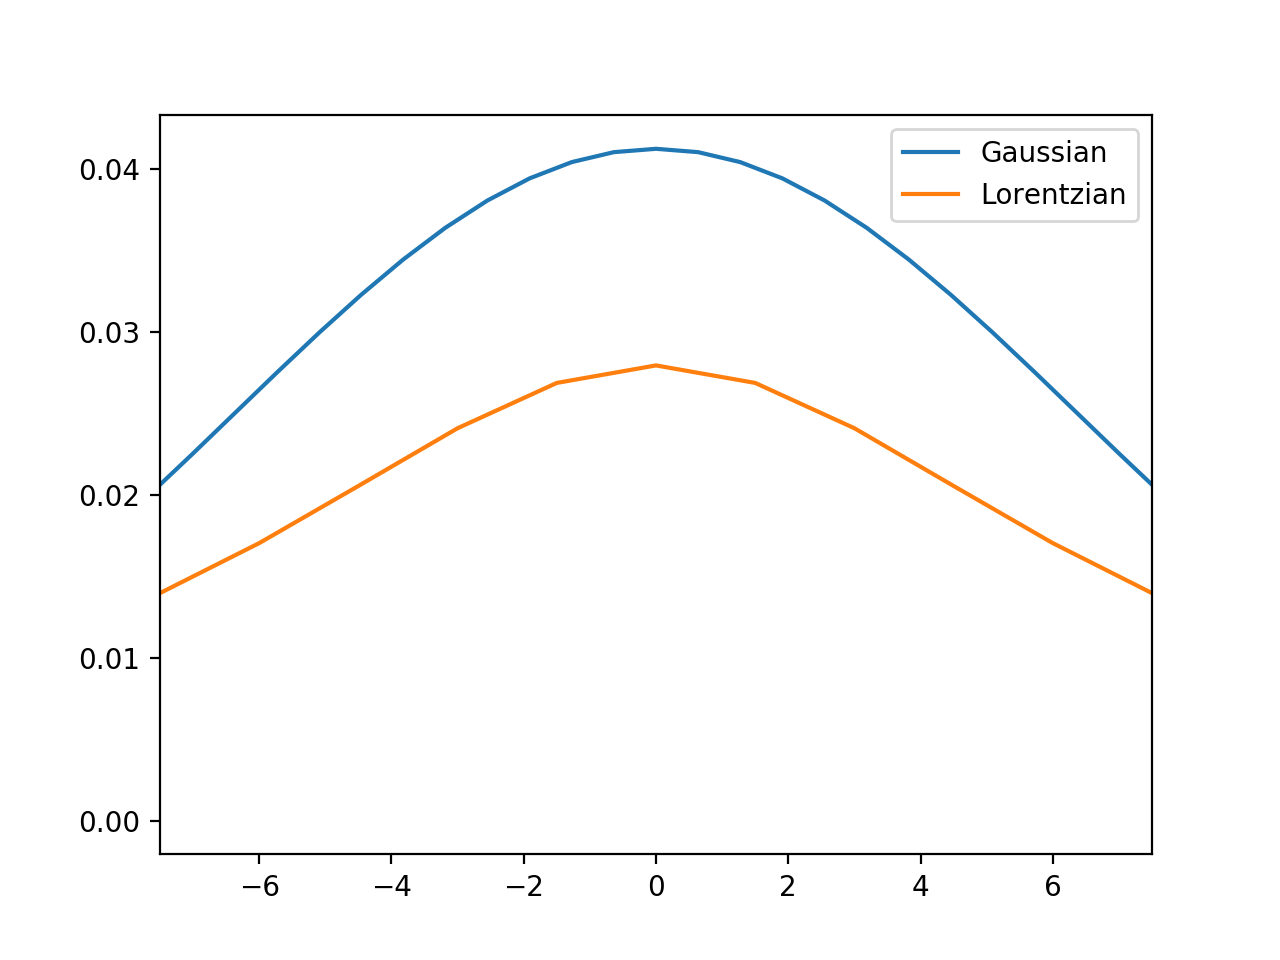

In [23]:
# verify FWHM
plt.figure()
plt.plot(eei2d_15fs_Gaussian.efield_times[0]*inverse_omega_0,eei2d_15fs_Gaussian.efields[0])
plt.plot(eei2d_15fs_Lorentzian.efield_times[0]*inverse_omega_0,eei2d_15fs_Lorentzian.efields[0])
plt.xlim([-7.5,7.5])
plt.legend(['Gaussian','Lorentzian'])

In [24]:
tau = np.array([0])

T = np.array([0])

eei2d_15fs_Gaussian.set_pulse_delays([tau,T])
eei2d_15fs_Lorentzian.set_pulse_delays([tau,T])

In [25]:
eei2d_15fs_Gaussian.calculate_signal([0,0,0,0])
print(len(eei2d_15fs_Gaussian.current_instructions))
instructions = eei2d_15fs_Gaussian.current_instructions

240


In [26]:
eei2d_15fs_Gaussian.calculate_signal([0,1000,2000,2000])
print(len(eei2d_15fs_Gaussian.current_instructions))
time_ordered_instructions = eei2d_15fs_Gaussian.current_instructions

7


In [27]:
eei2d_15fs_Gaussian.calculate_signal([0,0,1000,1000])
print(len(eei2d_15fs_Gaussian.current_instructions))
bac_instructions = eei2d_15fs_Gaussian.current_instructions

54


In [28]:
T = 100/inverse_omega_0
tau = np.arange(0,100,2)/inverse_omega_0
integrated_signals = np.zeros((len(instructions),tau.size))
abs_integrated_signals = np.zeros((len(instructions),tau.size))
time_ordered_indices = []
bac_indices = []
for j in range(len(instructions)):
    if instructions[j] in time_ordered_instructions:
        time_ordered_indices.append(j)
    elif instructions[j] in bac_instructions:
        bac_indices.append(j)
    for i in range(tau.size):
        sig = eei2d_15fs_Gaussian.calculate_diagrams([instructions[j]],[0,tau[i],T+tau[i],T+tau[i]])
        
        int_sig = np.real(np.trapz(sig,x=eei2d_15fs_Gaussian.w))
        integrated_signals[j,i] = int_sig
        int_abs_sig = np.trapz(np.abs(sig),x=eei2d_15fs_Gaussian.w)
        abs_integrated_signals[j,i] = int_abs_sig
        
time_ordered_indices = np.array(time_ordered_indices)
bac_indices = np.array(bac_indices)

np.savez('T100fs_Gaussian_FWHM_15fs',tau=tau*inverse_omega_0,diagram_strengths=abs_integrated_signals,
        time_ordered_indices = time_ordered_indices)

In [29]:
T = 100/inverse_omega_0
tau = np.arange(0,100,2)/inverse_omega_0
integrated_signals = np.zeros((len(instructions),tau.size))
abs_integrated_signals = np.zeros((len(instructions),tau.size))
time_ordered_indices = []
bac_indices = []
for j in range(len(instructions)):
    if instructions[j] in time_ordered_instructions:
        time_ordered_indices.append(j)
    elif instructions[j] in bac_instructions:
        bac_indices.append(j)
    for i in range(tau.size):
        sig = eei2d_15fs_Lorentzian.calculate_diagrams([instructions[j]],[0,tau[i],T+tau[i],T+tau[i]])
        
        int_sig = np.real(np.trapz(sig,x=eei2d_15fs_Lorentzian.w))
        integrated_signals[j,i] = int_sig
        int_abs_sig = np.trapz(np.abs(sig),x=eei2d_15fs_Lorentzian.w)
        abs_integrated_signals[j,i] = int_abs_sig
        
time_ordered_indices = np.array(time_ordered_indices)
bac_indices = np.array(bac_indices)

np.savez('T100fs_Lorentzian_FWHM_15fs',tau=tau*inverse_omega_0,diagram_strengths=abs_integrated_signals,
        time_ordered_indices = time_ordered_indices,bac_indices=bac_indices)

<IPython.core.display.Javascript object>


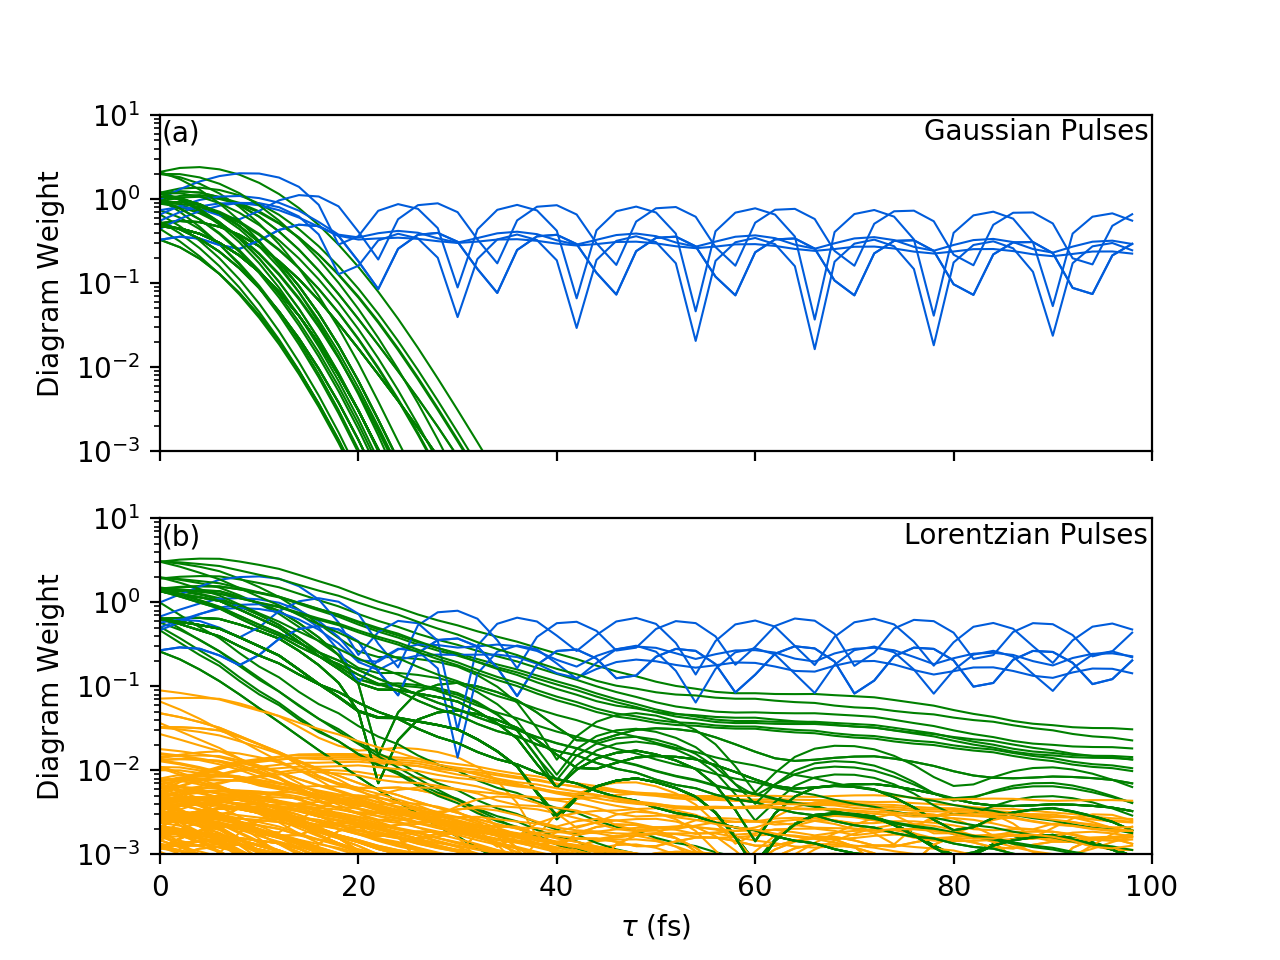

# of Lorentzian diagrams displayed 230
# of Gaussian diagrams displayed 54


In [30]:
arch1 = np.load('T100fs_Lorentzian_FWHM_15fs.npz')
arch2 = np.load('T100fs_Gaussian_FWHM_15fs.npz')

fig, [ax1,ax0] = plt.subplots(2,sharex=True)
x = arch1['tau']
y = arch1['diagram_strengths']
toi = arch1['time_ordered_indices']
y = y/np.max(y[toi,0])
print('# of Lorentzian diagrams displayed',np.where(np.max(y,axis=-1)>1E-3)[0].size)
for i in range(240):
    if i in toi:
        lc = '#005CDB'
    elif i in arch1['bac_indices']:
        lc = 'g'
    else:
        lc = 'orange'
    ax0.semilogy(x,y[i,:],c=lc,linewidth=0.75)
    
ax0.set_ylabel('Diagram Weight')
ax0.set_ylim([1E-3,10])
ax0.set_xlim([0,100])
ax0.text(75,5,'Lorentzian Pulses')
ax0.text(0.2,4.8,'(b)')
    
x2 = arch2['tau']
y2 = arch2['diagram_strengths']
toi = arch2['time_ordered_indices']
y2 = y2/np.max(y2[toi,0])
print('# of Gaussian diagrams displayed',np.where(np.max(y2,axis=-1)>1E-3)[0].size)
for i in range(240):
    if i in arch2['time_ordered_indices']:
        lc = '#005CDB'
    else:
        lc = 'g'
    ax1.semilogy(x2,y2[i,:],c=lc,linewidth=0.75)
ax1.set_ylim([1E-3,10])
ax1.set_xlim([0,100])
ax1.set_ylabel('Diagram Weight')
ax0.set_xlabel(r'$\tau$ (fs)')
ax1.text(77,5,'Gaussian Pulses')
ax1.text(0.2,4.8,'(a)')
l0, = ax1.plot(1E-10,1E-10,'r',linewidth=0.75)
l1, = ax1.plot(1E-10,1E-10,'g',linewidth=0.75)
l2, = ax1.plot(1E-10,1E-10,'teal',linewidth=0.75)
#ax1.set_title('T = 50 fs')
#leg = ax1.legend([l0,l1,l2],['abc','bac','cab/cba'],loc='lower right',fontsize=7)
#leg.set_title("Pulse order", prop = {'size':8})
fig.savefig('Lorentzian_Gaussian_15fs_FWHM_diagram_strengths_T100.png')
fig.savefig('Lorentzian_Gaussian_15fs_FWHM_diagram_strengths_T100.pdf')